In [2]:
# -*- coding: utf-8 -*-
"""
script №3 in order of applying
That script takes simplefast and purifier tick data and selects
crossed trends in near future, also every parameter of picture is calculated and the result
is written in dataframe. 
"""

import csv
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd

Для наглядности отобразим некоторые паттерны сопротивления (паттерны поддержки выглядят симметрично отностельно оси y = const)

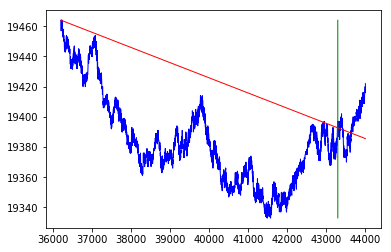

43307


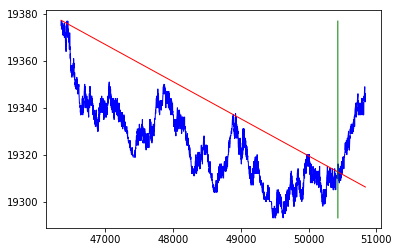

50432


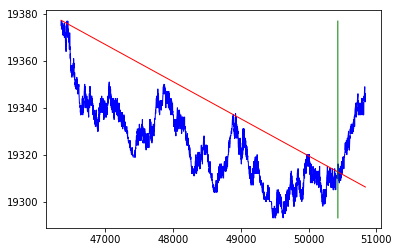

50432


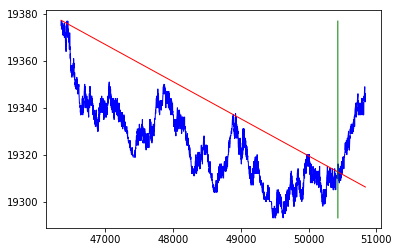

50432


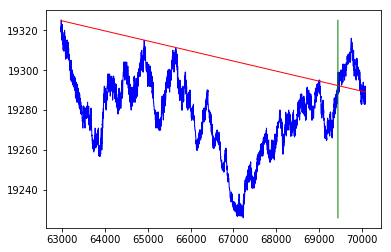

69442


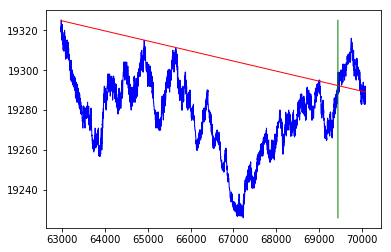

69442


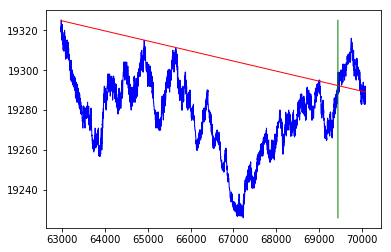

69442


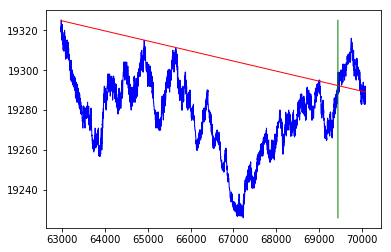

69442


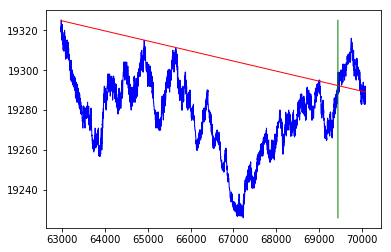

69442


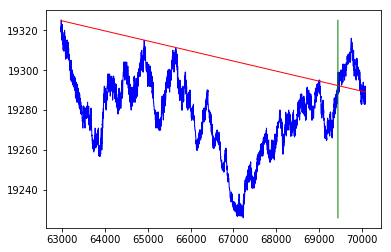

69442


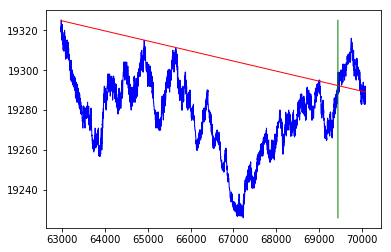

69442


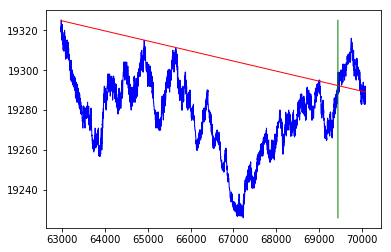

69442


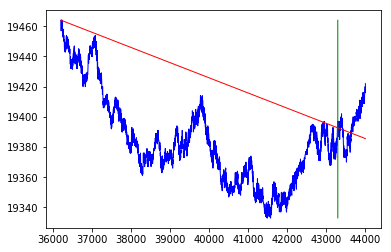

43307


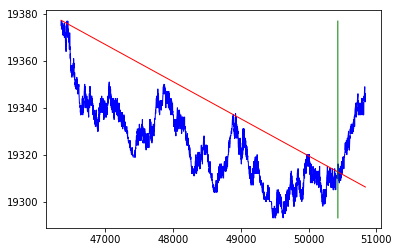

50432


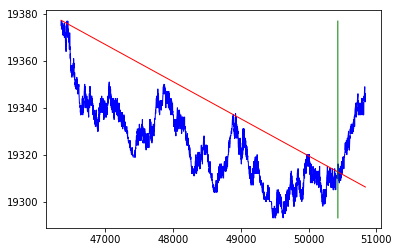

50432


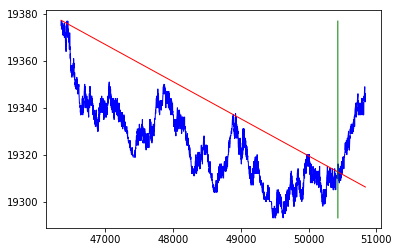

50432


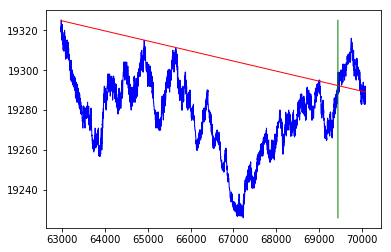

69442


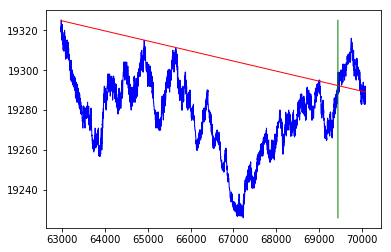

69442


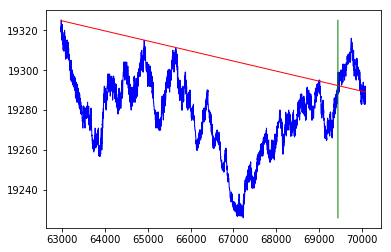

69442


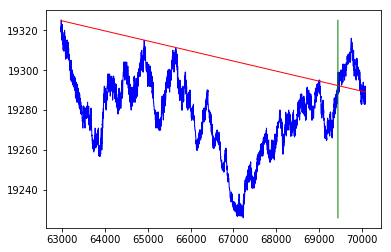

69442


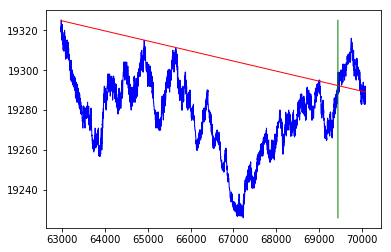

69442


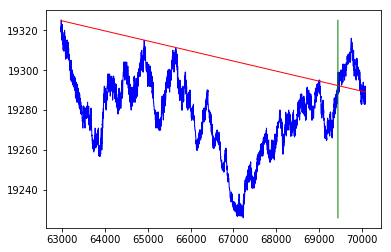

69442


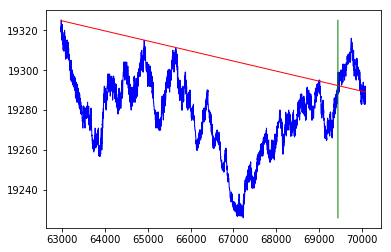

69442


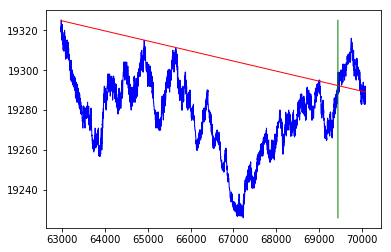

69442
       importance          k             b   dispersion  r_squared_of_trend  \
count   54.000000  54.000000     54.000000    54.000000           54.000000   
mean    23.423657   0.004584  19305.189087  1582.595000            0.923641   
std      7.274582   0.012929    457.955743  1783.324225            0.578343   
min     14.279111  -0.015850  18798.264571   792.000000            0.143231   
25%     16.355694  -0.005025  18890.572872   911.437500            0.462341   
50%     23.309867   0.001003  19243.594577  1025.500000            0.838180   
75%     31.545998   0.015378  19641.255520  1025.500000            1.451762   
max     38.203058   0.023609  20111.977306  9843.500000            1.889993   

       height_pic  
count   54.000000  
mean   112.814815  
std     43.478936  
min     84.000000  
25%     90.000000  
50%     99.000000  
75%     99.000000  
max    243.000000  


In [3]:
%matplotlib inline

tick_data_path = '../sber/pureSBER19.csv'
trendspath = '../sber/raw_signal.csv'
historyOutPath = '../sber/mature_signal.csv'
###############################################################################
colnames = ['<TIME>', '<VOLUME>', '<PRICE>']
mydataframe = pd.DataFrame(columns=['direction', 'trend_start', 'trend_end', 
                                    'importance', 'k', 'b', 'line_touching_x',
                                    'dispersion', 'trend_lenght', 'r_squared_of_trend', 
                                    'tops_coordinates','tops_height','tops_width',
                                    'tops_HW_ratio','tops_count','peaks_coordinates',
                                    'peaks_height','peaks_width','peaks_HW_ratio',
                                    'peaks_count', 'height_pic'])
data = pd.read_csv(tick_data_path, sep = ',', names=colnames, header = 0)
y_column = data['<PRICE>']
y_list = list(y_column)
x_list = list(range(len(y_list)))
###############################################################################
relax_coeff = 1# 100% длины в будущее до пересечения 
ticks_total = len(y_list) - 1          
Imin = 0
deep_of_trend_brokiness = 3 # пропорция найденных экстремумов под паттерном и над
current_line_index = 0
Lmin = 3000
wind = 40 
###############################################################################
def peakdetect(y_axis, x_axis, lookahead, delta):
    '''возвращает список экстремумов формата [(7647, 19033.5), (8441, 19070.0)]
    шириной >= lookahead и высотой > delta 
    '''
    maxtab = []
    mintab = []
    dump = []   #Used to pop the first hit which always if false
    length = len(y_axis)
    if x_axis is None:
        x_axis = range(length)
    y_axis = np.asarray(y_axis)
    mn, mx = np.Inf, -np.Inf
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x
        if y < mx-delta and mx != np.Inf:
            if y_axis[index:index+lookahead].max() < mx:
                maxtab.append((mxpos, mx))
                dump.append(True)
                mx = np.Inf
                mn = np.Inf
        if y > mn+delta and mn != -np.Inf:
            if y_axis[index:index+lookahead].min() > mn:
                mintab.append((mnpos, mn))
                dump.append(False)
                mn = -np.Inf
                mx = -np.Inf
    try:
        if dump[0]:
            maxtab.pop(0)
        else:
            mintab.pop(0)
        del dump
    except IndexError:
        pass
    return maxtab, mintab                
###############################################################################
    
def price(some):
    '''функция цены акции от номера тика (начало с 1) '''
    return (y_list[some])

def length (dot1, dot2):  
    '''декартово расстояние между точками'''
    return (np.linalg.norm(dot1-dot2))

def importance_of_line (number_of_dots,  length, dispersion_of_distance):
    '''коэффициент значимости паттерна  '''
    return(number_of_dots *  length/(dispersion_of_distance))
    
def find_zazor(pr):
    '''максимальное расстояние, начиная с которого будем считать, что
    паттерн не касается графика. Понятно, что оно зависит от абсолютного
    значения цены инструмента'''
    return (0.00005*pr)

###############################################################################
counter_list = []
with open (trendspath , "r") as csvfile: # файл с сырыми сигналами
    reader = csv.reader(csvfile, delimiter =  ",")
    raw_signal_list = list(reader)
    for i in raw_signal_list[2:]:
        try:
            direction_of_deal = int(i[0])
            first_dot = int(i[1])
            last_dot = int(i[2])
#            if last_dot <= 999999999 and last_dot > 0:
            angle = float(i[3])
            b_coeff = float(i[4])
            counter_list.append([first_dot, last_dot, angle, b_coeff, direction_of_deal])
        except:
            pass
        
for i in counter_list: # сигналы из файла с сырыми данными
    direction = i[-1]
    start_dot_2 = i[0]
    end_dot_2 = i[1]
    angle_2 = i[2]
    b_coeff_2 = i[3]
    relaxed_end_dot = relax_coeff*(end_dot_2 - start_dot_2) + end_dot_2
    zazor = find_zazor(price(end_dot_2))
    peakgrad = 10*zazor
    breakthrough = 3*zazor
    last_touching_list = []
    breakout_list = []
    for ii in x_list[end_dot_2: relaxed_end_dot]:
        if direction == 1 and angle_2 <= 0 :
            if abs(price(ii) - (ii*angle_2 + b_coeff_2)) <= zazor:
                last_touching_list.append(ii)
            if price(ii) - (ii*angle_2 + b_coeff_2) > breakthrough:
                breakout_list.append(ii)
                break
        if direction == 2 and angle_2 >= 0 :
            if abs(price(ii) - (ii*angle_2 + b_coeff_2)) <= zazor:
                last_touching_list.append(ii)
            if (ii*angle_2 + b_coeff_2) - price(ii) > breakthrough:
                breakout_list.append(ii)
                break
    #если было касание перед выходом из сопротивления и был сам выход            
    if len(last_touching_list) >= 0 and len(breakout_list) != 0:
        breakout = breakout_list[0] 
        end_dot_3 =  last_touching_list[-1]
###############################################################################
        y_list_whole_part = y_list[start_dot_2 : end_dot_3]
        x_list_whole_part = x_list[start_dot_2: end_dot_3]
        _max, _min = peakdetect(y_list_whole_part,x_list_whole_part, wind, peakgrad)
        max_listx= [x[0] for x in _max] 
        min_listx= [x[0] for x in _min]
        list_of_lists_max_3andmore_kasanie = [] #список абсцисс сопротивления
        list_of_lists_min_3andmore_kasanie = [] #список абсцисс поддержки
###############################################################################
        if direction == 1: # сопротивление
            list_double_couple_max = [(start_dot_2, price(start_dot_2)), (end_dot_2, price(end_dot_2))]
            np_double_couple_max = np.array(list_double_couple_max, dtype = np.dtype('int, float'))
            abscissa_list_max = np.array(np_double_couple_max["f0"], dtype = int) 
            ordinata_list_max = np.array(np_double_couple_max['f1'], dtype = float) 
            A = np.vander(abscissa_list_max, 2)
            #coeff = [a,b] где coeff[0] - это тангенс угла наклона, а coeff[1] - +b 
            coeff_max, sse_max, rank_max , sing_a_max = np.linalg.lstsq(A,ordinata_list_max, rcond=-1)
            coeff_max = list(coeff_max)
            list_kasanie_max = [] 
            list_kasanie_max_broken = []
            dots_above_line_max = 0 # вышли за пределы сопротивления
            dots_under_line_max = 0
            for i in max_listx: # итерации сборa касаний 
               if (price(i) - (float(coeff_max[0] * i) + float(coeff_max[1]))) > zazor:
                   dots_above_line_max += 1
                   list_kasanie_max = []
               elif (float(coeff_max[0] * i) + float(coeff_max[1]) - price(i)) > zazor:
                   dots_under_line_max += 1
               else:
                   list_kasanie_max.append(i)
                   list_kasanie_max_broken.append(i)
            list_kasanie_max.append(end_dot_3)       
            list_kasanie_max_broken.append(end_dot_3)  
            #паттерн захватывает последнюю точку и длиннее минимальной величины
            if (list_kasanie_max[-1] - list_kasanie_max[0]) > Lmin and len(list_kasanie_max) > 4: 
                list_of_lists_max_3andmore_kasanie.append(list_kasanie_max)
        max_set = set(tuple(x) for x in list_of_lists_max_3andmore_kasanie)
        max_list_abscissa = [list(x) for x in max_set] # это список абсцисс # индексы совпадают
        #   _max  пары (x,y) max_listx (x)
        max_list_ordinata = [] # индексы совпадают
        list_of_var_max = [] # индексы совпадают
        importance_max = [] # индексы совпадают
        importance_max_val = [] # индексы совпадают
        list_angle_max = [] # индексы совпадают
        list_sse_max = []# индексы совпадают
        real_distance_max_list = [] # индексы совпадают  
        ##__списки со списками параметров вершин и пиков, таких как высоты, основания, острота и т.д.
        tops_max_parameters = [] # индексы совпадают/ список списков [list_peaks, list_of_peaks_H, list_of_peak_W]
        peak_max_parameters = [] # индексы совпадают/ список списков [list_tops, list_of_tops_H, list_of_tops_W]
        # более точно перестраиваем паттерн по >=4 точкам
        for i in max_list_abscissa: # i - список абсцисс касаний вида [x1, x2, x3..]
            d = [price(ii) for ii in i]
            max_list_ordinata.append(d)
        for i, ii in zip (max_list_abscissa, max_list_ordinata):
            list_tops = []      # список вида [(x1, y1), (x2, y2)---] с координатами вершины
            list_of_tops_H = []    # список вида [x1, x2, ...] с высотой вершины отн паттерна
            list_of_tops_W = [] # список вида [x1, x2, ...] с шириной основания вершины
            real_distance_max_list.append(math.hypot(i[-1] - i[0], ii[-1] - ii[0]))
            A = np.vander(i, 2)
            coeff_max, sse_max, rank_max , sing_a_max = np.linalg.lstsq(A, ii, rcond=-1)
            coeff_max = list(coeff_max)
            sse_max = sse_max[0]
            list_angle_max.append(coeff_max)
            list_sse_max.append(sse_max)
            amount_of_peaks_on_line = len(i)
            for l in range(amount_of_peaks_on_line - 1):
                k = i[l +1]
                j = i[l]
                min_selected = [x for x in _min if (x[0] >= j and x[0] <= k)]
                if len(min_selected) > 0:# найдена нормальная вершина в этом интервале
                    min_selected_y = [x[1] for x in min_selected]
                    local_top_y = min(min_selected_y)
                    list_of_tops_W.append((k-j))
                    local_top = [x for x in min_selected if x[1] == local_top_y][0]
                    list_tops.append(local_top)
                    local_top_H =  abs(coeff_max[0]*local_top[0] + coeff_max[1] - local_top_y)
                    list_of_tops_H.append(local_top_H)
                    ## выдумываем первую и последнюю вершину 
                    if l == 0:
                        x_of_first_top = j - (k - j)
                        local_top = (x_of_first_top, local_top_y)
                        list_tops.insert(0,local_top)
                        list_of_tops_W.insert(0, (k-j))
                        list_of_tops_H.insert(0, local_top_H)
                    if l == amount_of_peaks_on_line - 2:
                        x_of_last_top = k + (k - j)
                        local_top = (x_of_last_top, local_top_y)
                        list_tops.append(local_top)
                        list_of_tops_W.append((k-j))
                        list_of_tops_H.append(local_top_H)
                else: # вершина в интервале не найдена. будем использовать середину интервала
                    min_selected = int((k + j)/2)
                    local_top_y = price(min_selected)
                    list_of_tops_W.append((k-j))
                    local_top = (min_selected, local_top_y)
                    list_tops.append(local_top)
                    local_top_H =   abs(coeff_max[0]*local_top[0] + coeff_max[1] - local_top_y)
                    list_of_tops_H.append(local_top_H)
                    ## выдумываем первую и последнюю вершину 
                    if l == 0:
                        x_of_first_top = j - (k - j)
                        local_top = (x_of_first_top, local_top_y)
                        list_tops.insert(0,local_top)
                        list_of_tops_W.insert(0, (k-j))
                        list_of_tops_H.insert(0, local_top_H)
                    if l == amount_of_peaks_on_line - 2:
                        x_of_last_top = k + (k - j)
                        local_top_y = min(y_list[j:breakout])
                        local_top = (x_of_last_top, local_top_y)
                        list_tops.append(local_top)
                        list_of_tops_W.append((k-j))
                        list_of_tops_H.append(local_top_H)
            tops_sharpness = [(x/y) for x,y in zip(list_of_tops_H, list_of_tops_W)] 
            tops_max_parameters.append([list_tops, list_of_tops_H, list_of_tops_W, tops_sharpness])
        for i, j, k in zip(max_list_abscissa, tops_max_parameters, max_list_ordinata): #между образующими паттерн пиками есть по 1 вершине
            list_peaks = [(x, y) for x,y in zip(i, k)]      # список вида [(x1, y1), (x2, y2)---] с координатами пиков
            list_of_peak_H = [] # список вида [x1, x2, ...] с высотой пиков отн паттерна соседних вершин
            list_of_peak_W = [] # список вида [x1, x2, ...] с шириной пиков по соседним вершинам  
            list_peaks = [(x, y) for x,y in zip(i, k)]
            jj = j[0]
            for l in range(len(i)):
                peak_x = i[l]
                peak_y = k[l]
                first_neighbour_top = jj[l]
                second_neighbour_top = jj[l + 1]
                peak_W = second_neighbour_top[0] - first_neighbour_top[0]
                tg_angle = (second_neighbour_top[1] - first_neighbour_top[1])/(peak_W)
                b_coeff = first_neighbour_top[1] - tg_angle*first_neighbour_top[0]
                peak_H = peak_y - tg_angle*peak_x - b_coeff
                list_of_peak_W.append(peak_W)
                list_of_peak_H.append(peak_H)
            peak_sharpness = [(x/y) for x,y in zip(list_of_peak_H, list_of_peak_W)] 
            peak_max_parameters.append([list_peaks, list_of_peak_H, list_of_peak_W, peak_sharpness])
        for i in max_list_abscissa:
            c =  [x-x2 for x, x2 in zip(i[1:], i[:-1])]
            mean_distance = np.mean(c)
            cc = [(abs(x - mean_distance)) for x in c]
            list_of_var_max.append(np.mean(cc))
        for i1, i2, i5, i6 in zip(max_list_abscissa, list_of_var_max, real_distance_max_list, list_sse_max):
            importance_max.append(importance_of_line((len(i1)), i5, i2))
            importance_max_val.append([i1, i2, i5, i6])            
        #######################№№##############################################         
        if direction == 2:
            list_double_couple_min = [(start_dot_2, price(start_dot_2)), (end_dot_2, price(end_dot_2))]
            np_double_couple_min = np.array(list_double_couple_min, dtype = np.dtype('int, float'))
            abscissa_list_min = np.array(np_double_couple_min["f0"], dtype = int) # список значений абсциссы
            ordinata_list_min = np.array(np_double_couple_min['f1'], dtype = float) # список значений ординаты
            A = np.vander(abscissa_list_min, 2)
            coeff_min, sse_min, rank_min , sing_a_min = np.linalg.lstsq(A,ordinata_list_min, rcond=-1)
            coeff_min = list(coeff_min)
    #       coeff = [a,b] где coeff[0] - это тангенс угла наклона, а coeff[1] - +b 
            list_kasanie_min = [] # временный список значений абсцыссы, в которых касательная касается графика в 3 и более точках
            list_kasanie_min_broken = []
            dots_above_line_min = 0 # вышли за пределы паттерна
            dots_under_line_min = 0
            for i in min_listx: # сбор касаний я начинаю с первой точки
                if (float(coeff_min[0] * i) + float(coeff_min[1]) - price(i)) > zazor: 
                    dots_above_line_min += 1
                    list_kasanie_min = []
                elif (price(i) - (float(coeff_min[0] * i) + float(coeff_min[1]))) > zazor:
                    dots_under_line_min += 1
                else:
                    list_kasanie_min.append(i)
                    list_kasanie_min_broken.append(i)
            list_kasanie_min.append(end_dot_3)       
            list_kasanie_min_broken.append(end_dot_3)
            #паттерн захватывает последнюю точку и длиннее минимума
            if (list_kasanie_min[-1] - list_kasanie_min[0]) > Lmin and len(list_kasanie_min) > 4: 
                list_of_lists_min_3andmore_kasanie.append(list_kasanie_min)
    ###########################################################################
        min_set = set(tuple(x) for x in list_of_lists_min_3andmore_kasanie)
        min_list_abscissa = [list(x) for x in min_set] # это список абсцисс # индексы совпадают
        #   _max  пары (x,y) max_listx (x)
        min_list_ordinata = [] # индексы совпадают
        list_of_var_min = [] # индексы совпадают
        importance_min = [] # индексы совпадают
        importance_min_val = [] # индексы совпадают
        list_angle_min = [] # индексы совпадают
        list_sse_min = []# индексы совпадают
        real_distance_min_list = [] # индексы совпадают  
        ##__списки со списками параметров вершин и пиков, таких как высоты, основания, острота и т.д.
        tops_min_parameters = [] # индексы совпадают/ список списков [list_peaks, list_of_peaks_H, list_of_peak_W]
        peak_min_parameters = [] # индексы совпадают/ список списков [list_tops, list_of_tops_H, list_of_tops_W]
        ####____определяем уравнение паттерна####################################
        for i in min_list_abscissa: # i - список абсцисс касаний вида [x1, x2, x3..]
            d = [price(ii) for ii in i]
            min_list_ordinata.append(d)
        for i, ii in zip (min_list_abscissa, min_list_ordinata):
            list_tops = []      # список вида [(x1, y1), (x2, y2)---] с координатами вершины
            list_of_tops_H = []    # список вида [x1, x2, ...] с высотой вершины отн паттерна
            list_of_tops_W = [] # список вида [x1, x2, ...] с шириной основания вершины
            real_distance_min_list.append(math.hypot(i[-1] - i[0], ii[-1] - ii[0]))
            A = np.vander(i, 2)
            coeff_min, sse_min, rank_min , sing_a_min = np.linalg.lstsq(A, ii, rcond=-1)
            coeff_min = list(coeff_min)
            sse_min = sse_min[0]
            list_angle_min.append(coeff_min)
            list_sse_min.append(sse_min)
            amount_of_peaks_on_line = len(i)
            for l in range(amount_of_peaks_on_line - 1):
                k = i[l +1]
                j = i[l]
                max_selected = [x for x in _max if (x[0] >= j and x[0] <= k)]
                if len(max_selected) > 0:# найдена нормальная вершина в этом интервале
                    max_selected_y = [x[1] for x in max_selected]
                    local_top_y = max(max_selected_y)
                    list_of_tops_W.append((k-j))
                    local_top = [x for x in max_selected if x[1] == local_top_y][0]
                    list_tops.append(local_top)
                    local_top_H = abs(local_top_y - coeff_min[0]*local_top[0] - coeff_min[1])
                    list_of_tops_H.append(local_top_H)
                    # генерируем первую и последнюю вершину, отражая половинки 
                    if l == 0:
                        x_of_first_top = j - (k - j)
                        local_top = (x_of_first_top, local_top_y)
                        list_tops.insert(0,local_top)
                        list_of_tops_W.insert(0, (k-j))
                        list_of_tops_H.insert(0, local_top_H)
                    if l == amount_of_peaks_on_line - 2:
                        x_of_last_top = k + (k - j)
                        local_top = (x_of_last_top, local_top_y)
                        list_tops.append(local_top)
                        list_of_tops_W.append((k-j))
                        list_of_tops_H.append(local_top_H)
                else: # вершина в интервале не найдена. будем использовать середину интервала
                    max_selected = int((k + j)/2)
                    local_top_y = price(max_selected)
                    list_of_tops_W.append((k-j))
                    local_top = (max_selected, local_top_y)
                    list_tops.append(local_top)
                    local_top_H = abs(local_top_y - coeff_min[0]*local_top[0] - coeff_min[1])
                    list_of_tops_H.append(local_top_H)
                    # генерируем первую и последнюю вершину, отражая половинки
                    if l == 0:
                        x_of_first_top = j - (k - j)
                        local_top = (x_of_first_top, local_top_y)
                        list_tops.insert(0,local_top)
                        list_of_tops_W.insert(0, (k-j))
                        list_of_tops_H.insert(0, local_top_H)
                    if l == amount_of_peaks_on_line - 2:
                        x_of_last_top = k + (k - j)
                        local_top_y = max(y_list[j:breakout])
                        local_top = (x_of_last_top, local_top_y)
                        list_tops.append(local_top)
                        list_of_tops_W.append((k-j))
                        list_of_tops_H.append(local_top_H)
            tops_sharpness = [(x/y) for x,y in zip(list_of_tops_H, list_of_tops_W)] 
            tops_min_parameters.append([list_tops, list_of_tops_H, list_of_tops_W, tops_sharpness])
        for i, j, k in zip(min_list_abscissa, tops_min_parameters, min_list_ordinata): #между образующими паттерн пиками есть по 1 вершине
            list_peaks = [(x, y) for x,y in zip(i, k)]      # список вида [(x1, y1), (x2, y2)---] с координатами пиков
            list_of_peak_H = [] # список вида [x1, x2, ...] с высотой пиков отн паттерна соседних вершин
            list_of_peak_W = [] # список вида [x1, x2, ...] с шириной пиков по соседним вершинам  
            list_peaks = [(x, y) for x,y in zip(i, k)]
            jj = j[0]
            for l in range(len(i)):
                peak_x = i[l]
                peak_y = k[l]
                first_neighbour_top = jj[l]
                second_neighbour_top = jj[l + 1]
                peak_W = second_neighbour_top[0] - first_neighbour_top[0]
                tg_angle = (second_neighbour_top[1] - first_neighbour_top[1])/(peak_W)
                b_coeff = first_neighbour_top[1] - tg_angle*first_neighbour_top[0]
                peak_H = tg_angle*peak_x + b_coeff - peak_y
                list_of_peak_W.append(peak_W)
                list_of_peak_H.append(peak_H)
            peak_sharpness = [(x/y) for x,y in zip(list_of_peak_H, list_of_peak_W)] 
            peak_min_parameters.append([list_peaks, list_of_peak_H, list_of_peak_W, peak_sharpness])
        for i in min_list_abscissa:
            c =  [x-x2 for x, x2 in zip(i[1:], i[:-1])]
            mean_distance = np.mean(c)
            cc = [(abs(x - mean_distance)) for x in c]
            list_of_var_min.append(np.mean(cc))
        for i1, i2, i5, i6 in zip(min_list_abscissa, list_of_var_min, real_distance_min_list, list_sse_min):
            importance_min.append(importance_of_line((len(i1)), i5, i2))
            importance_min_val.append([i1, i2, i5, i6])
        #######################################################################
        if len(importance_min) > 0:
            b = max(importance_min)
            if b > Imin:
                the_best_min = b
                the_best_min_index = ([i for i, j in enumerate(importance_min) if j == the_best_min])
                the_best_min_index_value = the_best_min_index[0]
                fb = min_list_abscissa[the_best_min_index_value][0]
                lb = min_list_abscissa[the_best_min_index_value][-1]
                the_best_min_index_value = the_best_min_index[0]
                height_pic = max(y_list[fb:breakout]) - min(y_list[fb:breakout]) 
                mydataframe.loc[current_line_index] = [2, fb, breakout, the_best_min, list_angle_min[the_best_min_index_value][0], list_angle_min[the_best_min_index_value][1], importance_min_val[the_best_min_index_value][0], importance_min_val[the_best_min_index_value][1], (breakout - fb), importance_min_val[the_best_min_index_value][3],  tops_min_parameters[the_best_min_index_value][0], tops_min_parameters[the_best_min_index_value][1], tops_min_parameters[the_best_min_index_value][2], tops_min_parameters[the_best_min_index_value][3], len(tops_min_parameters[the_best_min_index_value][0]), peak_min_parameters[the_best_min_index_value][0], peak_min_parameters[the_best_min_index_value][1], peak_min_parameters[the_best_min_index_value][2], peak_min_parameters[the_best_min_index_value][3], len(peak_min_parameters[the_best_min_index_value][0]), height_pic]
                current_line_index += 1
        if len(importance_max) > 0:
            a = max(importance_max)
            if a > Imin:
                the_best_max = a
                the_best_max_index = ([i for i, j in enumerate(importance_max) if j == the_best_max]) 
                the_best_max_index_value = the_best_max_index[0]
                fa = max_list_abscissa[the_best_max_index_value][0]
                la = max_list_abscissa[the_best_max_index_value][-1]
                the_best_max_index_value = the_best_max_index[0]
                height_pic = max(y_list[fa:breakout]) - min(y_list[fa:breakout]) 
                mydataframe.loc[current_line_index] = [1, fa, breakout, the_best_max, list_angle_max[the_best_max_index_value][0], list_angle_max[the_best_max_index_value][1], importance_max_val[the_best_max_index_value][0], importance_max_val[the_best_max_index_value][1], (breakout - fa), importance_max_val[the_best_max_index_value][3],  tops_max_parameters[the_best_max_index_value][0], tops_max_parameters[the_best_max_index_value][1], tops_max_parameters[the_best_max_index_value][2], tops_max_parameters[the_best_max_index_value][3], len(tops_max_parameters[the_best_max_index_value][0]), peak_max_parameters[the_best_max_index_value][0], peak_max_parameters[the_best_max_index_value][1], peak_max_parameters[the_best_max_index_value][2], peak_max_parameters[the_best_max_index_value][3], len(peak_max_parameters[the_best_max_index_value][0]), height_pic]
                current_line_index += 1
                #################################################################
                win = la - fa
                past_window = la -win
                future_window = la +int(win/10)
                xplot = x_list[(past_window):(future_window)]
                yplot = y_list[(past_window):(future_window)] 
                xx = x_list[(past_window) : (future_window)]
                boarder_x1 = [la, la +1]
                boarder_y1 = [max(yplot), min(yplot)]
                boarder_x2 = [fa, fa +1]
                boarder_y2 = boarder_y1
                line = []
                angle = list_angle_max[the_best_max_index_value][0]
                b_coeff = list_angle_max[the_best_max_index_value][1]
                for ii in xx:
                    line.append(angle*ii + b_coeff)
                lines = plt.plot(xplot, yplot, xx, line, boarder_x1, boarder_y1)
                l1, l2, l3 = lines
                plt.setp(lines, linestyle='-')
                plt.setp(l1, linewidth=1, color='b')
                plt.setp(l2, linewidth=1, color='r')
                plt.setp(l3, linewidth=1, color='g')
                plt.show()
                plt.pause(0.05)
                print(la)
                ###################################################################

print(mydataframe.describe())
mydataframe.to_csv(historyOutPath, index=False)

Видим, что не смотря на отсутствие повторяющихся паттернов в сырых данных, многие имеют пересечение с графиком
в одной и той же точке. Нужно будет учесть этот факт.